<a href="https://colab.research.google.com/github/cipher982/GNN-playground/blob/main/dgl_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Neural Networks
By David Rose

## Graphs TL;DR

## What?
A graph is a method of representing a network data and the connections between. In the most basic form you have two parts that make up a graph: **nodes** and **edges**.

The nodes represent the samples of data and the edges represent some sort of link between them. Sometimes the link can be a single obvious property connecting multiple objects such as:
- Distances between cities in miles
- Friendships on Facebook
- Citations between papers on Arxiv

Or sometimes the network can be connected by multiple relevant attributes. With the Amazon goods supply chain you will have numeroud routes that can be described by:
- The trucks that deliver on routes between warehouses
- The type of route (sea, land, air)
- The average time or cost to transfer between locations

## Why?
Compared to tabular datasets there is no assumption of IID, rather the intent with graphs is the express purpose of the samples of data being related in some way or another. 

## How?
We can transition a graph to the form of a typical machine learning problem by giving both the nodes and the edges their own features, and then performing the task of classifying a label on a specific node or a graph as a whole. Maybe for COVID contact tracing we are wanting to find who may have had contact with a specific person (node) but we only have partial knowledge of contact so far (the labels true/false) based on the edge features (distance in where they live) and node features (demographics, job type, common locations visited).

Features can be anything you would normally use in a dataset:
- numerical embeddings of words on a webage
- pixel values of images
- one-hot encoding of categories

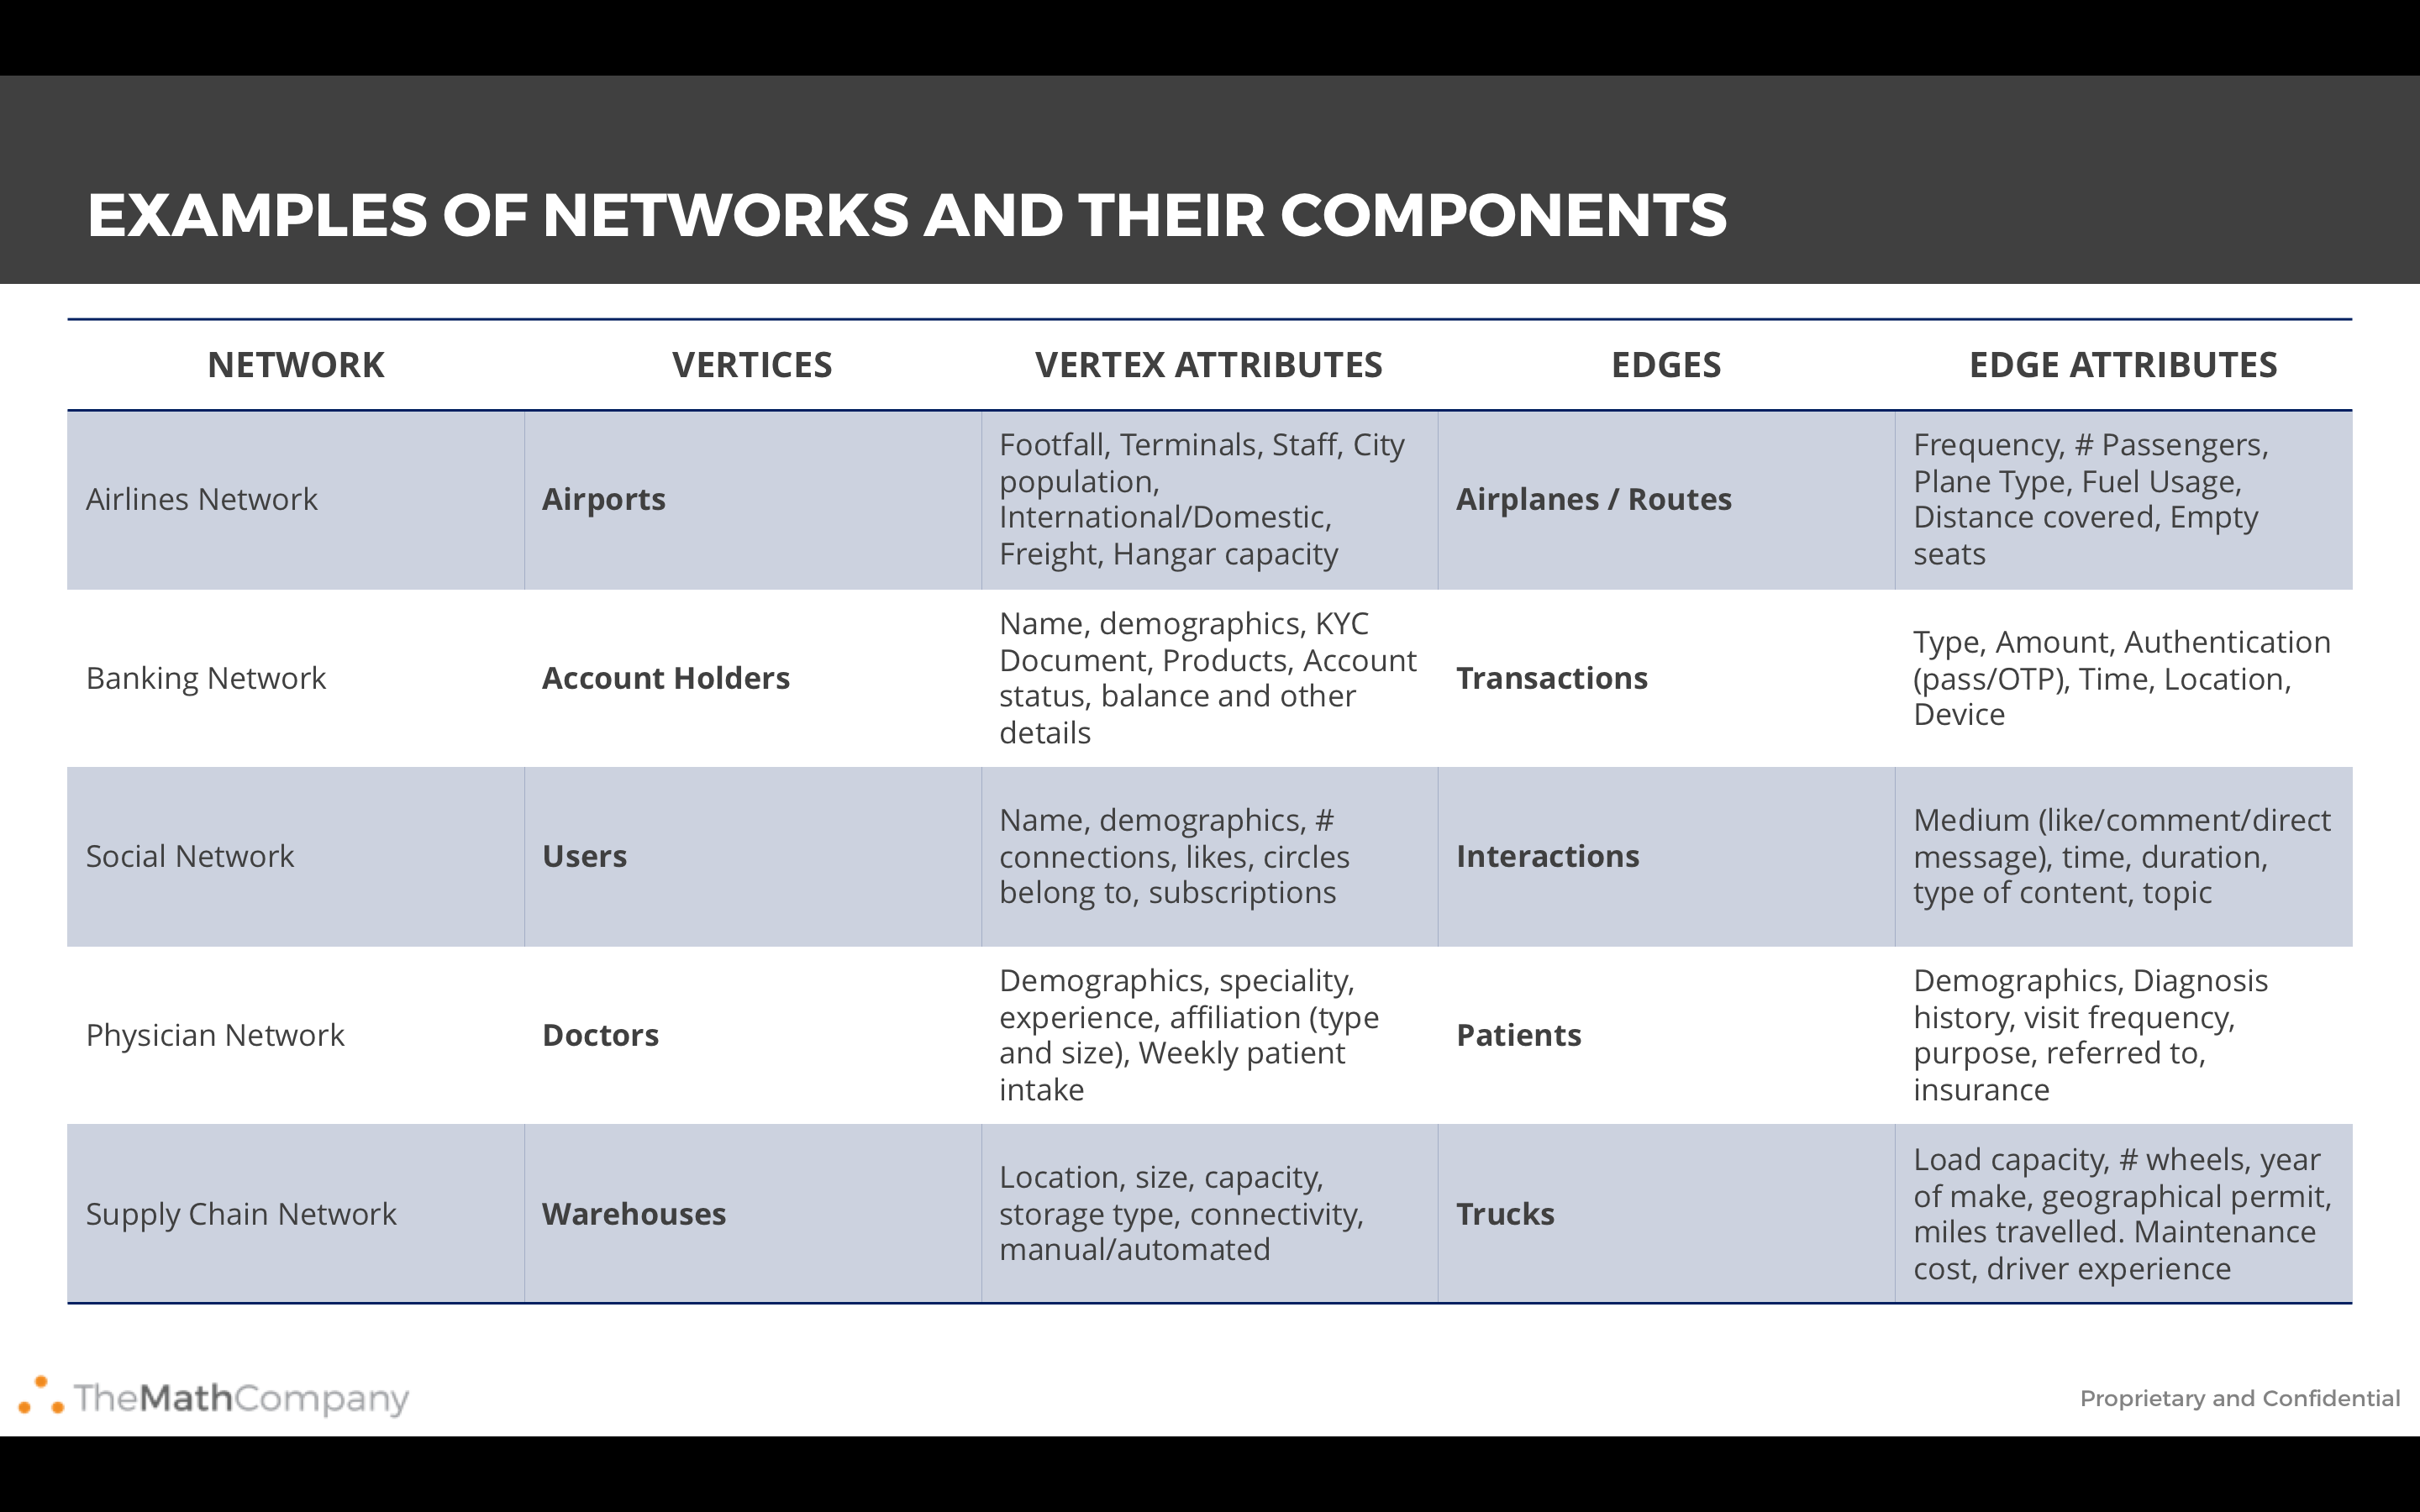

# History

The first mention was in 2009 in a paper from the University of Wollongong, Australia. They proposed the idea of a *Graph Neural Network Model* that builds as an extension of recursive neural networks and random walk models.

# Example
### Node Classification

The basic idea is that we can take a specific reference node, in this case node A, and perform neighborhood aggregation on the sorrounding nodes and the edges between them.

#### What are the network layers?
- **Nodes**: Recurrent networks
- **Edges**: feed-forward networks

#### What is the process?
**Message passing**: In performing the neighborhoood aggregation, we pass messages (or embeddings) between the sorrounding nodes in regards to our reference node A. This in effect causes the information embedded in the nodes and edges to began filtering through the network, where they begin to learn from their neighbors.

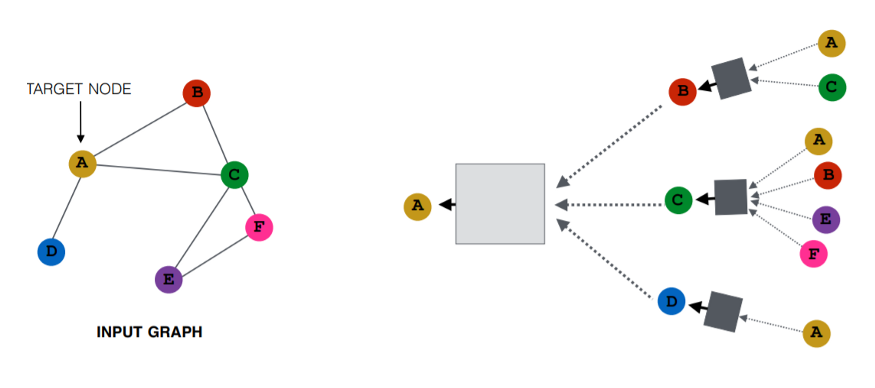

### Simple steps:
1. Neighboring nodes pass their messages (embeddings) through the edge networks into the recurrent network on the refernce node.
2. The new embedding of the reference recurrent unit is updated by applying the recurrent function on the current embedding and a summation of the edge network outputs from enighboring nodes.

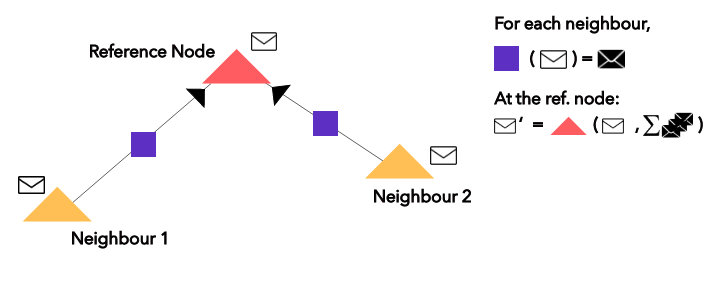

## Then what?

Once you have performed this step a few times, we now have a set of new embeddings, different from than we began. So the nodes now have their original information, along with an aggregation of the information contained within their sorrounding nodes. We can then take this information and and send them further along other layers in a pipeline, or sum up all the embeddings to get a vector **H** that represents the whole graph.

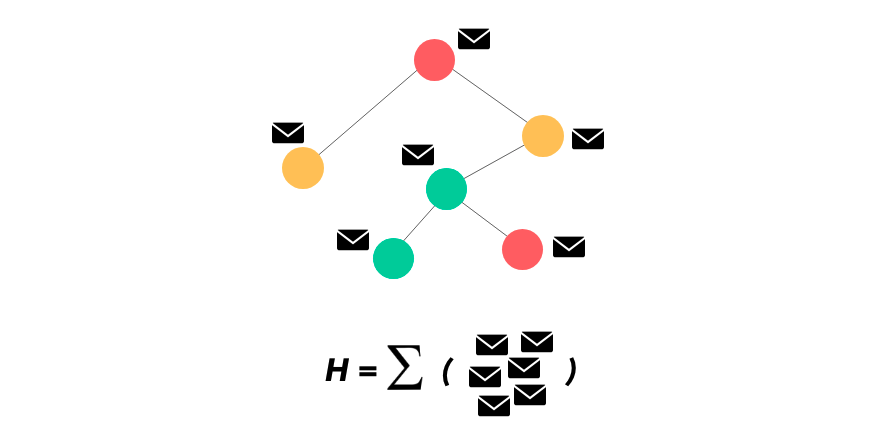

## Math Notation

### State of each node
Each node is represented by the state of it's neigborhood below

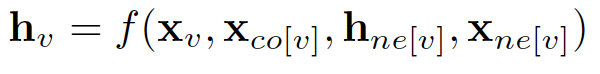

- **x_v**: The node feature
- **x_co[v]**: Features of the edges connecting with v
- **h_ne[v]**: Embeddings of the neighboring nodes of v
- **x_nv[v]**: Features of the neighboring nodes of v
- **f**: The transition function that projects these inputs into a d-dimensional space


### State of aggregate nodes
H and X denote the concatenation of all the h and x values as an iterative update process

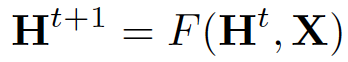

## Typical Sampling Process

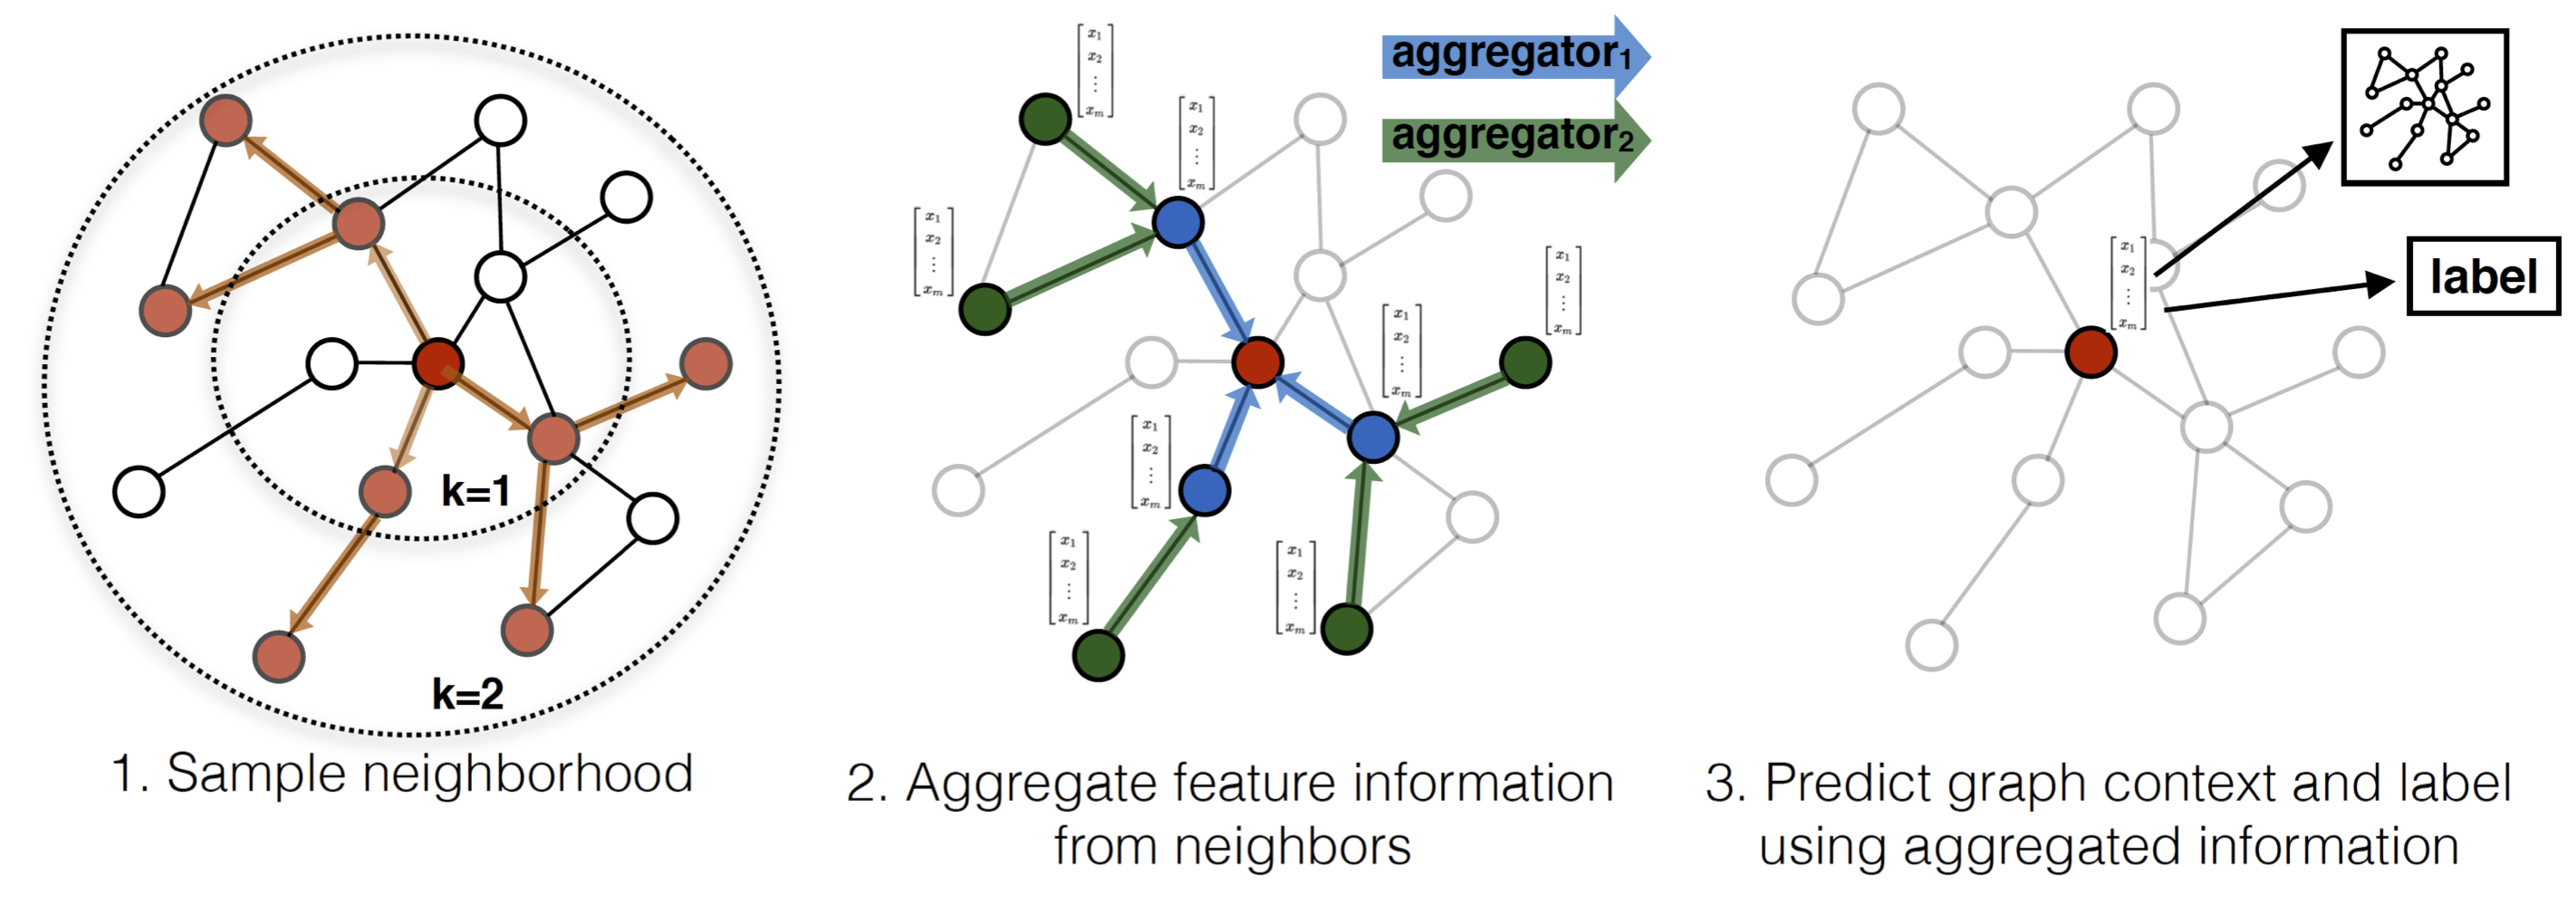

-------------

# Code Example

In [ ]:
!pip install dgl torch > logs/bash_log.txt

### PyTorch or TensorFlow?

When importing *dgl* we can specify the backend to use with the environmental variable `DGLBACKEND`.

In [11]:
#%env DGLBACKEND='tensorflow'
%env DGLBACKEND='pytorch'

import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.data

USE_GPU = False

env: DGLBACKEND='pytorch'


### Dataset (Reddit)

Using the Reddit dataset which has already been processed and ready for download. It is a collection of posts made during the month of September 2014. The label is the subreddit name for the node (post) and nodes are connected if the same user comments on both.

#### Sampling
We use the first 20 days for training and the remaining days for testing (with 30% used for validation).

In [2]:
#dataset = dgl.data.CoraGraphDataset()
dataset = dgl.data.RedditDataset()

In [3]:
print('Number of categories:', dataset.num_classes)

g = dataset[0]
print('\nNode features')

print(g.ndata.keys())
print('\nEdge features')
print(g.edata.keys())

print(f"\nTotal nodes: {g.num_nodes():,}")
print(f"Total edges: {g.num_edges():,}")

Number of categories: 41

Node features
dict_keys(['label', 'feat', 'test_mask', 'train_mask', 'val_mask'])

Edge features
dict_keys([])

Total nodes: 232,965
Total edges: 114,615,892


## The Model

Here we put together a simple two-layer Graph Convolutional Network (GCN). Each layer computes new node representations by aggregating neighbor information.

DGL layers work easily within PyTorch and can be stacked along with standard PyTorch layers.

In [7]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

# Create the model with given dimensions
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)

## Training

The training process is basically similar to any other PyTorch training loop.

In [8]:
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    for e in range(50):
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Only compute the losses of the nodes in the training set
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save best validation accuracy and corresponding test accuracy
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            print(
            'epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}),\
            test acc: {:.3f} (best {:.3f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))

if USE_GPU:            
    g = g.to('cuda')
    model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes).to('cuda')
else:
    model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)

train(g, model)

epoch 0, loss: 3.755, val acc: 0.011 (best 0.011),            test acc: 0.011 (best 0.011)
epoch 5, loss: 2.773, val acc: 0.362 (best 0.362),            test acc: 0.362 (best 0.362)
epoch 10, loss: 2.177, val acc: 0.598 (best 0.598),            test acc: 0.595 (best 0.595)
epoch 15, loss: 1.716, val acc: 0.665 (best 0.665),            test acc: 0.660 (best 0.660)
epoch 20, loss: 1.355, val acc: 0.759 (best 0.759),            test acc: 0.754 (best 0.754)
epoch 25, loss: 1.083, val acc: 0.824 (best 0.824),            test acc: 0.820 (best 0.820)
epoch 30, loss: 0.888, val acc: 0.857 (best 0.857),            test acc: 0.853 (best 0.853)
epoch 35, loss: 0.756, val acc: 0.894 (best 0.894),            test acc: 0.891 (best 0.891)
epoch 40, loss: 0.661, val acc: 0.902 (best 0.902),            test acc: 0.899 (best 0.899)
epoch 45, loss: 0.593, val acc: 0.912 (best 0.912),            test acc: 0.909 (best 0.909)


## Save the trained graph

Once the model is trained we can easily save it and load back later on with the built-in functions.

In [10]:
# Save graphs
dgl.save_graphs('graph.dgl', g)

# Load graphs
(g,), _ = dgl.load_graphs('graph.dgl')
print(g)

Graph(num_nodes=232965, num_edges=114615892,
      ndata_schemes={'val_mask': Scheme(shape=(), dtype=torch.uint8), 'train_mask': Scheme(shape=(), dtype=torch.uint8), 'test_mask': Scheme(shape=(), dtype=torch.uint8), 'label': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(602,), dtype=torch.float32)}
      edata_schemes={})
